# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
import torch
import torchvision
from torchvision.datasets import FakeData
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Dati per la normalizzazione CIFAR-10 
CIFAR_MEAN = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).to(device)
CIFAR_STD = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1).to(device)


# Normalizzazione costanti come tensori per passarle alle funzioni
CIFAR_MEAN_TENSOR = CIFAR_MEAN 
CIFAR_STD_TENSOR = CIFAR_STD

In [5]:

# Trasformazioni per il TRAINING (con Data Augmentation)
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR_MEAN.squeeze().tolist(), std=CIFAR_STD.squeeze().tolist()) # Usa le costanti definite prima
])

# Trasformazioni per il TEST e OOD (senza Data Augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR_MEAN.squeeze().tolist(), std=CIFAR_STD.squeeze().tolist()) # Usa le costanti definite prima
])

batch_size = 256 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train) # Uso transform_train
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test) # Uso transform_test

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform_test) # Uso transform_test anche per FakeData
fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


horse


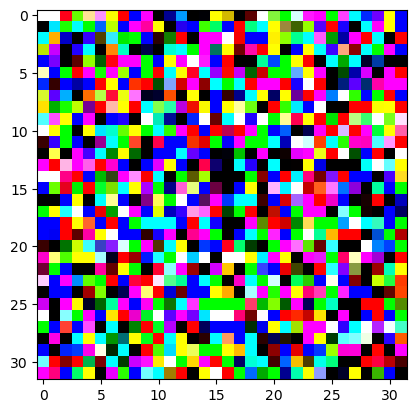

In [6]:
for data in fakeloader:
    x, y = data
    plt.imshow(x[0,:].permute(1,2,0))
    print(classes[y[0]])
    break

In [7]:
trainset.classes[y[0]]

'horse'

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Blocco Convoluzionale 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64x16x16

        # Blocco Convoluzionale 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 128x8x8

        # Blocco Convoluzionale 3 
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 256x4x4

        # Classificatore Lineare
        # La dimensione di input per il primo layer lineare deve essere calcolata correttamente:
        # 256 canali * 4x4 dimensione della feature map finale = 256 * 16 = 4096

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout1 = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5) 
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = F.relu(self.bn5(self.conv5(x))) 
        x = F.relu(self.bn6(self.conv6(x))) 
        x = self.pool3(x)                   

        x = x.view(x.size(0), -1) # Flatten

        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [9]:

model = CNN().to(device)

loss =  nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Aggiungo un learning rate scheduler (StepLR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1) # Riduci LR del 90% ogni 50 epoche


In [10]:
model

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [11]:
def train_model(model, trainloader, loss_fn, optimizer, epochs):
    model.train()
    for e in range(epochs):
        running_loss = 0
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            yp = model(x)
            l = loss_fn(yp, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            running_loss += l.item()
        scheduler.step() # Aggiorna il learning rate    
        print(f"Epoch {e}: Loss {running_loss/len(trainloader):.4f}")


In [12]:
train_model(model, trainloader, loss, optimizer, epochs=50)


Epoch 0: Loss 1.6431
Epoch 1: Loss 1.1528
Epoch 2: Loss 0.9322
Epoch 3: Loss 0.7920
Epoch 4: Loss 0.6809
Epoch 5: Loss 0.5894
Epoch 6: Loss 0.5036
Epoch 7: Loss 0.4277
Epoch 8: Loss 0.3656
Epoch 9: Loss 0.3144
Epoch 10: Loss 0.2543
Epoch 11: Loss 0.2068
Epoch 12: Loss 0.1669
Epoch 13: Loss 0.1304
Epoch 14: Loss 0.1224
Epoch 15: Loss 0.1021
Epoch 16: Loss 0.0805
Epoch 17: Loss 0.0740
Epoch 18: Loss 0.0644
Epoch 19: Loss 0.0622
Epoch 20: Loss 0.0532
Epoch 21: Loss 0.0573
Epoch 22: Loss 0.0484
Epoch 23: Loss 0.0489
Epoch 24: Loss 0.0466
Epoch 25: Loss 0.0501
Epoch 26: Loss 0.0434
Epoch 27: Loss 0.0370
Epoch 28: Loss 0.0391
Epoch 29: Loss 0.0411
Epoch 30: Loss 0.0322
Epoch 31: Loss 0.0376
Epoch 32: Loss 0.0343
Epoch 33: Loss 0.0452
Epoch 34: Loss 0.0399
Epoch 35: Loss 0.0315
Epoch 36: Loss 0.0428
Epoch 37: Loss 0.0317
Epoch 38: Loss 0.0359
Epoch 39: Loss 0.0275
Epoch 40: Loss 0.0321
Epoch 41: Loss 0.0273
Epoch 42: Loss 0.0286
Epoch 43: Loss 0.0301
Epoch 44: Loss 0.0310
Epoch 45: Loss 0.033

In [13]:
torch.save(model.state_dict(), './cifar10_CNN_2.pth')

In [14]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.
model = CNN().to(device)
#model.load_state_dict(torch.load('./cifar10_CNN_new.pth')) #fully trained
model.load_state_dict(torch.load('./cifar10_CNN_2.pth')) #50 epochs


<All keys matched successfully>

In [15]:
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model(x)

    y_pred.append(yp.argmax(1))
    y_gt.append(y)


In [16]:
(yp.argmax(1)== y).sum()/yp.shape[0]

tensor(0.6250, device='cuda:0')

Accuracy: 0.7975999712944031


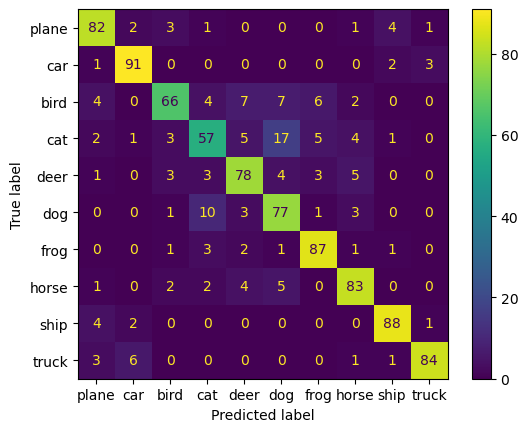

In [17]:
#Here we look at accuracy and confusion matrix

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
print(f'Accuracy: {accuracy}')
from sklearn import metrics

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)

cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=classes)
disp.plot()
plt.show()


tensor(7, device='cuda:0')


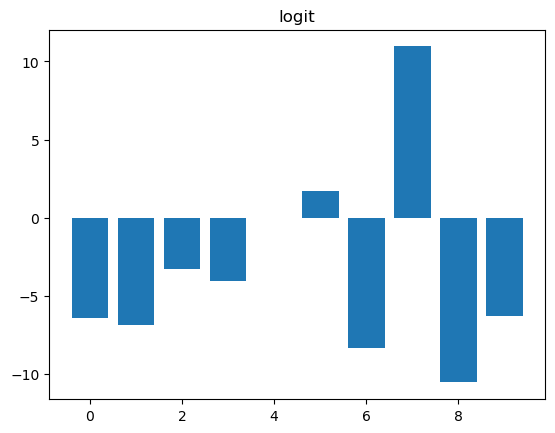

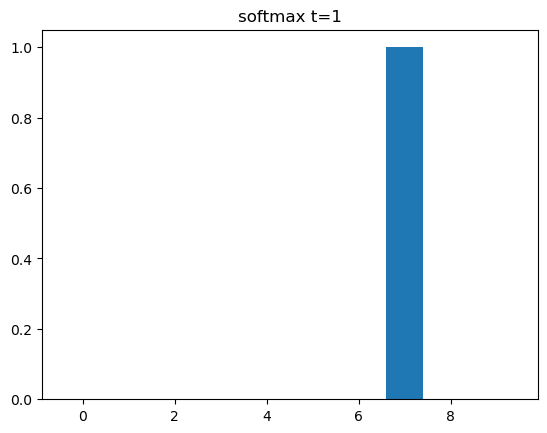

In [18]:
#Example of logit and softmax output
k=6
print(y[k])
output = model(x)
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

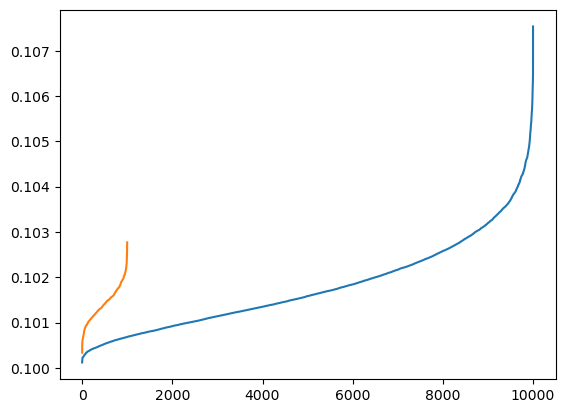

In [19]:
def max_logit(logit):
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp=1000
scores_test = compute_scores(testloader, lambda l: max_softmax(l, T=temp))
scores_fake = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp))


plt.plot(sorted(scores_test.cpu()))
plt.plot(sorted(scores_fake.cpu()))


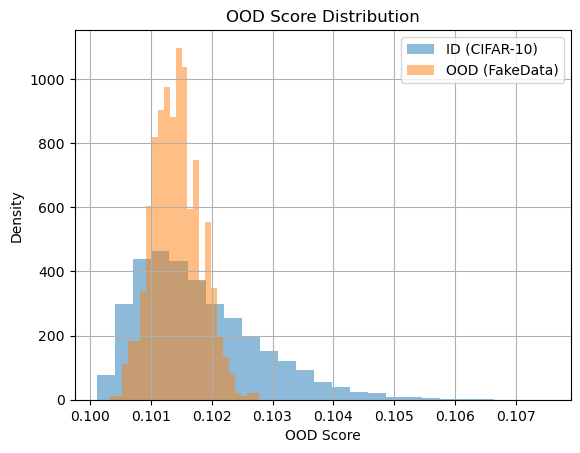

In [20]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25, label="ID (CIFAR-10)")
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25, label="OOD (FakeData)")
plt.xlabel("OOD Score")
plt.ylabel("Density")
plt.title("OOD Score Distribution")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [22]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)

In [23]:
epochs = 150
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
    print(e, running_loss/len(trainloader))

0 1.5579376512644243
1 1.1534579341508904
2 1.093709575886629
3 1.0612420278544328
4 1.0441525295680882
5 1.0366688273390945
6 1.030746653676033
7 1.026628207795474
8 1.023173885686057
9 1.0199250213953914
10 1.0175798638742797
11 1.0148645627255342
12 1.012341141092534
13 1.0099795399879923
14 1.0075533481276766
15 1.0052491259209964
16 1.0027004653701976
17 0.9995898677378284
18 0.9849014081517045
19 0.9752921468141128
20 0.9719292576215706
21 0.9691886263234275
22 0.9663894036594702
23 0.9641675286147059
24 0.9625657240346986
25 0.961216212535391
26 0.9596976309406514
27 0.9583111295894701
28 0.9570204436170812
29 0.9563661658642243
30 0.9553711715401435
31 0.9542457634697155
32 0.9536533091141253
33 0.9531729786979909
34 0.9520607967765964
35 0.9513998040739371
36 0.9503917131496935
37 0.9503147285811755
38 0.9490432441234589
39 0.948112710702176
40 0.9482226158891406
41 0.9475829212033019
42 0.946753957441875
43 0.9463356337985214
44 0.946274642433439
45 0.9458068250393381
46 0.94

In [24]:
def compute_ae_scores(dataloader, model_ae):
    model_ae.eval()
    scores = []
    loss = nn.MSELoss(reduction='none')
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            _, xr = model_ae(x)
            l = loss(x, xr)
            score = l.mean(dim=[1, 2, 3])  # mean su ogni immagine
            scores.append(-score)  # negativo perché errore alto = più OOD
    return torch.cat(scores)


scores_test_ae = compute_ae_scores(testloader, model_ae)
scores_fake_ae = compute_ae_scores(fakeloader, model_ae)

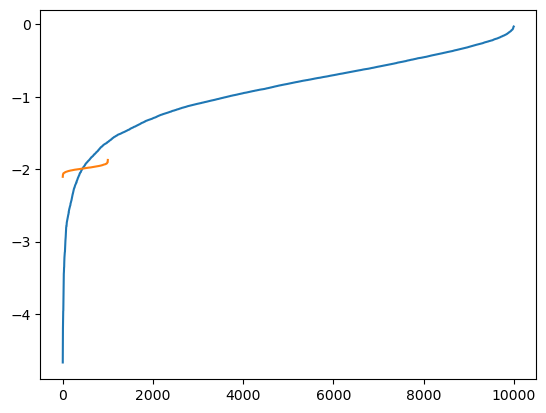

In [25]:
plt.plot(sorted(scores_test_ae.cpu()))
plt.plot(sorted(scores_fake_ae.cpu()))

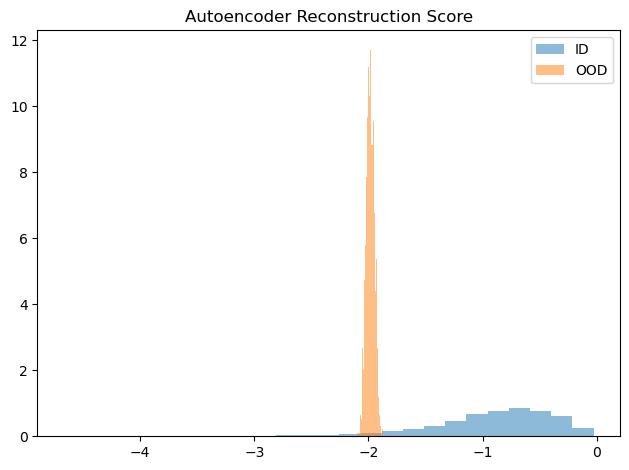

In [26]:
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25, label='ID')
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25, label='OOD')
plt.title("Autoencoder Reconstruction Score")
plt.legend()
plt.tight_layout()
plt.show()

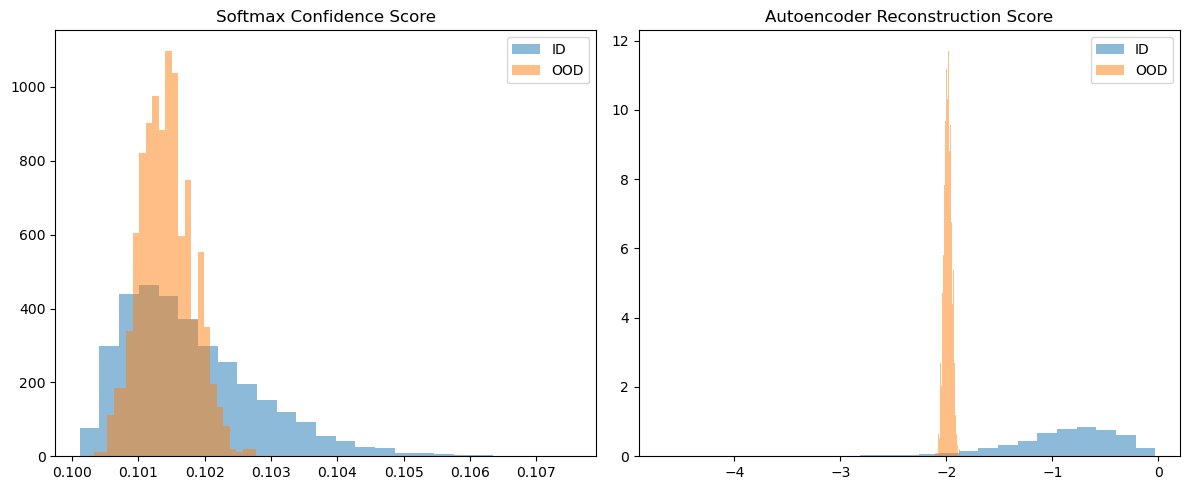

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25, label='ID')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25, label='OOD')
plt.title("Softmax Confidence Score")
plt.legend()

plt.subplot(1,2,2)
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25, label='ID')
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25, label='OOD')
plt.title("Autoencoder Reconstruction Score")
plt.legend()
plt.tight_layout()
plt.show()

| Obiettivo                               | Completato? | Note                                                    |
| --------------------------------------- | ----------- | ------------------------------------------------------- |
| ⚙️ Pipeline OOD detection               | ✅           | Hai usato due metodi diversi: max softmax e autoencoder |
| 🧠 Dataset ID/OOD distinti              | ✅           | CIFAR-10 (ID) e FakeData (OOD)                          |
| 🔍 Score "OOD-ness" per campione        | ✅           | Max softmax e −MSE per AE                               |
| 📊 Analisi qualitativa (es. istogrammi) | ✅           | Confronto visivo tra ID e OOD                           |
| 🧪 Validazione separata da training     | ✅           | CIFAR-10 `test` usato correttamente                     |


### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



In [28]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

def plot_ood_metrics(scores_id, scores_ood, title=""):
    
    # Plotta ROC e Precision-Recall curve per OOD detection usando score continuo (più alto = più ID).
    
    y_pred = torch.cat((scores_id, scores_ood))
    y_true = torch.cat((
        torch.ones_like(scores_id),   # ID → 1
        torch.zeros_like(scores_ood) # OOD → 0
    ))

    y_pred = y_pred.cpu()
    y_true = y_true.cpu()

    print(f"\n{title}")
    RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.title(f"ROC Curve - {title}")
    plt.grid()
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_true, y_pred)
    plt.title(f"Precision-Recall Curve - {title}")
    plt.grid()
    plt.show()


Autoencoder -MSE


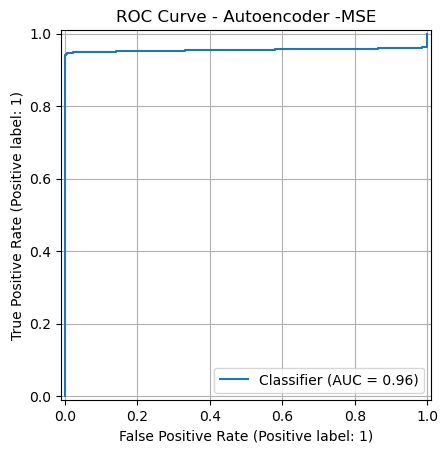

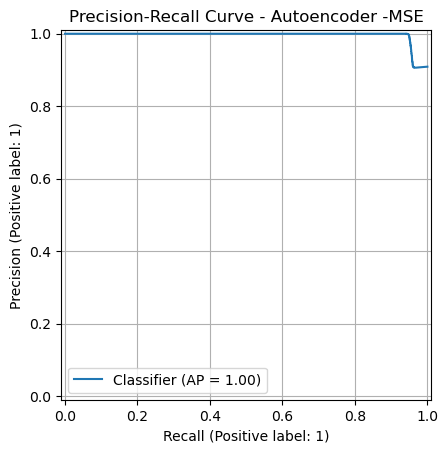


Max Softmax (T=1000)


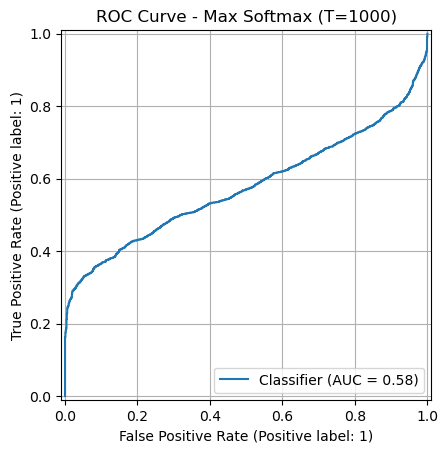

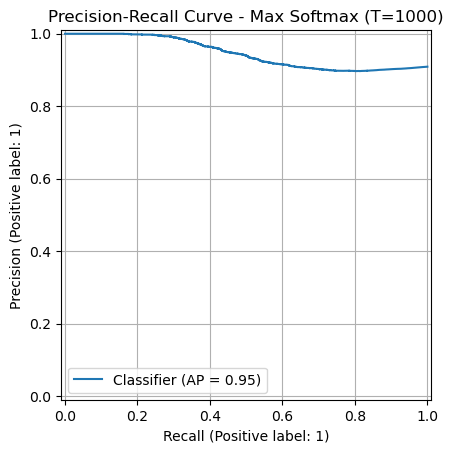

In [29]:
# AE performance
plot_ood_metrics(scores_test_ae, scores_fake_ae, title="Autoencoder -MSE")

# Softmax confidence
plot_ood_metrics(scores_test, scores_fake, title="Max Softmax (T=1000)")

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

In [43]:
class NormalizeInverse(torchvision.transforms.Normalize):
    # Inverti la normalizzazione (mean=0.5, std=0.5 → torna allo spazio [0,1])
    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse(CIFAR_MEAN.squeeze().tolist(), CIFAR_STD.squeeze().tolist())

In [44]:
# Crea il dizionario per mapping nome_classe -> indice
class_dict = {class_name: idx for idx, class_name in enumerate(testset.classes)}

# Mostra classi disponibili
for i, c in enumerate(testset.classes):
    print(i, c)


0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


In [45]:
model.eval() # Assicurati che il modello sia in eval mode
loss_fgsm = nn.CrossEntropyLoss() # Rinominato per chiarezza, prima era 'loss'

# Funzione per trovare un sample classificato correttamente
def find_correctly_classified_sample(model, dataloader, device):
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        with torch.no_grad():
            output = model(x_batch)
            preds = output.argmax(dim=1)
        for j in range(len(y_batch)):
            if preds[j] == y_batch[j]:
                return x_batch[j][None, :].clone(), y_batch[j][None]
    raise RuntimeError("Nessun sample correttamente classificato trovato nel testloader!")

# --- Funzione per generare e valutare attacchi (FGSM Iterativo/PGD) ---
# Nota: Questa implementazione è per FGSM Iterativo (o PGD), non il FGSM one-step classico,
# dato che include max_iter > 1 e clamping per ogni passo.

In [46]:
def generate_and_evaluate_adversarial_example(model, original_x, true_y, target_label, eps_step, max_iter, targeted_attack, inv_transform, classes_names, loss_func, device):
    x_adv = original_x.clone().detach().to(device)
    x_adv.requires_grad = True # Solo una volta all'inizio della funzione

    before = x_adv.clone().detach() # Salva l'immagine originale (normalizzata) per il confronto

    # Prepara target per l'attacco
    target = torch.tensor([target_label]).to(device) if targeted_attack else true_y.clone().to(device)

    done = False
    n = 0

    print(f"Attacco {'mirato' if targeted_attack else 'non mirato'} con eps_step={eps_step:.5f} e max_iter={max_iter}")
    
    while not done and n < max_iter:
        # Non serve più x_adv.requires_grad = True qui dentro.
        # È già stato impostato all'inizio e rimane tale perché usiamo operazioni in-place.
        
        output = model(x_adv) # Usa x_adv per il forward pass

        model.zero_grad() # Azzera i gradienti dei parametri del modello
        # Non è necessario azzerare x_adv.grad qui; l.backward() se ne occuperà

        l = loss_func(output, target)
        l.backward() # Calcola i gradienti rispetto a x_adv

        with torch.no_grad(): # Le modifiche a x_adv devono essere fuori dal grafico computazionale
            grad_sign = x_adv.grad.sign() # Prendi il segno del gradiente

            if targeted_attack:
                x_adv.sub_(eps_step * grad_sign) # Operazione in-place
            else:
                x_adv.add_(eps_step * grad_sign) # Operazione in-place

            x_adv.clamp_(0, 1) # Clampa in-place i valori dei pixel nell'intervallo [0,1] normalizzato

        n += 1
        # Controlla la previsione corrente per decidere se l'attacco è riuscito
        pred = output.argmax().item() # Usa l'output dell'ultima iterazione per la predizione

        if not targeted_attack and pred != true_y.item(): # Usa true_y (non y che è il target per l'attacco)
            print(f"  Successo: Attacco non mirato (predetto {classes_names[pred]} vs vero {classes_names[true_y.item()]}) al budget {int(255 * n * eps_step)}/255")
            done = True
        if targeted_attack and pred == target.item():
            print(f"  Successo: Attacco mirato (predetto {classes_names[pred]} vs target {classes_names[target.item()]}) al budget {int(255 * n * eps_step)}/255")
            done = True
    if not done:
        print(f"  Attacco {'mirato' if targeted_attack else 'non mirato'} fallito dopo {max_iter} iterazioni. Predetto: {classes_names[pred]}")

    # --- Valutazione Quantitativa ---
    output_adv = model(x_adv)
    softmax_adv = F.softmax(output_adv, dim=1)
    predicted_adv_class = output_adv.argmax().item()
    confidence_adv = softmax_adv[0, predicted_adv_class].item()
    print(f"  Confidenza predizione avversaria finale ({classes_names[predicted_adv_class]}): {confidence_adv:.4f}")

    # Norma L-infinito della perturbazione (nello spazio normalizzato)
    perturbation_norm_linf = (x_adv - before).abs().max().item()
    print(f"  Norma L-infinito della perturbazione finale: {perturbation_norm_linf:.6f}")

    # --- Visualizzazioni ---
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # Immagine originale (non normalizzata per la visualizzazione)
    img_orig = torch.clamp(inv_transform(before[0]), 0, 1)
    axs[0].imshow(img_orig.permute(1, 2, 0).detach().cpu())
    axs[0].set_title(f"Originale: {classes_names[true_y.item()]}\nPred: {classes_names[model(before).argmax().item()]}")
    axs[0].axis('off')

    # Immagine avversaria (non normalizzata per la visualizzazione)
    img_adv = torch.clamp(inv_transform(x_adv[0]), 0, 1)
    axs[1].imshow(img_adv.permute(1, 2, 0).detach().cpu())
    axs[1].set_title(f"Avversaria (eps={eps_step:.4f}):\nPred: {classes_names[predicted_adv_class]}")
    axs[1].axis('off')

    # Differenza (perturbazione scalata per visibilità)
    diff = (x_adv - before).detach() # Differenza nello spazio normalizzato
    visual_scale_factor = 5 # Puoi regolare questo fattore
    perturbation_vis = diff[0] * visual_scale_factor + 0.5
    perturbation_vis = torch.clamp(perturbation_vis, 0, 1)
    axs[2].imshow(perturbation_vis.permute(1, 2, 0).cpu())
    axs[2].set_title("Perturbazione Scalata (+0.5)")
    axs[2].axis('off')

    # Heatmap della perturbazione media per canale (valore assoluto)
    heatmap = (255 * diff.squeeze().abs().mean(0)).cpu()
    im = axs[3].imshow(heatmap, cmap='hot')
    fig.colorbar(im, ax=axs[3], fraction=0.046, pad=0.04)
    axs[3].set_title("Heatmap Perturbazione Media (L1 avg)")
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()

    return done, predicted_adv_class, confidence_adv, perturbation_norm_linf # Ritorna risultati

In [47]:
# --- Esecuzione dell'attacco per diversi Epsilon ---
# Trova un sample valido (classificato correttamente) una sola volta
x_original_sample, y_original_sample = find_correctly_classified_sample(model, testloader, device)

true_label = y_original_sample.item()
possible_targets = [i for i in range(len(classes)) if i != true_label] # Usiamo 'classes'
target_label = possible_targets[5] # Puoi randomizzare se vuoi

print(f"Esempio Originale: {classes[true_label]}")
print(f"Target per Attacco Mirato: {classes[target_label]}")

Esempio Originale: cat
Target per Attacco Mirato: frog



--- Generazione e Valutazione Esempi Avversari ---

Generando attacco con step epsilon: 0.0010
Attacco mirato con eps_step=0.00100 e max_iter=100
  Successo: Attacco mirato (predetto frog vs target frog) al budget 8/255
  Confidenza predizione avversaria finale (frog): 0.3434
  Norma L-infinito della perturbazione finale: 2.208062


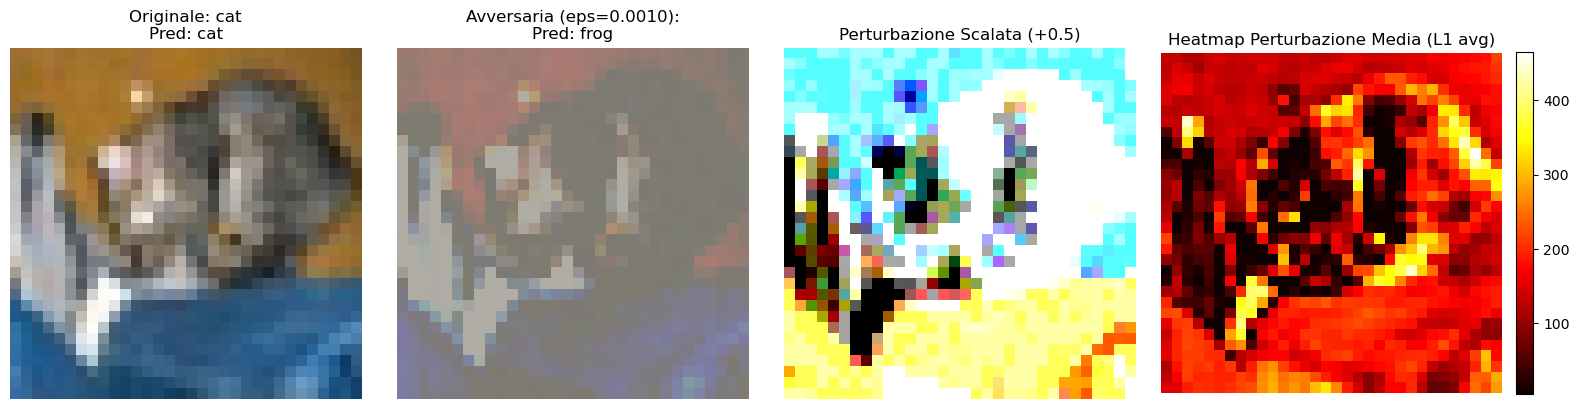

Risultato finale per eps_step 0.0010: Successo=True, Predetto=frog, Confidenza=0.3434, Norma L-inf=2.208062

Generando attacco con step epsilon: 0.0020
Attacco mirato con eps_step=0.00200 e max_iter=100
  Successo: Attacco mirato (predetto frog vs target frog) al budget 8/255
  Confidenza predizione avversaria finale (frog): 0.3488
  Norma L-infinito della perturbazione finale: 2.209062


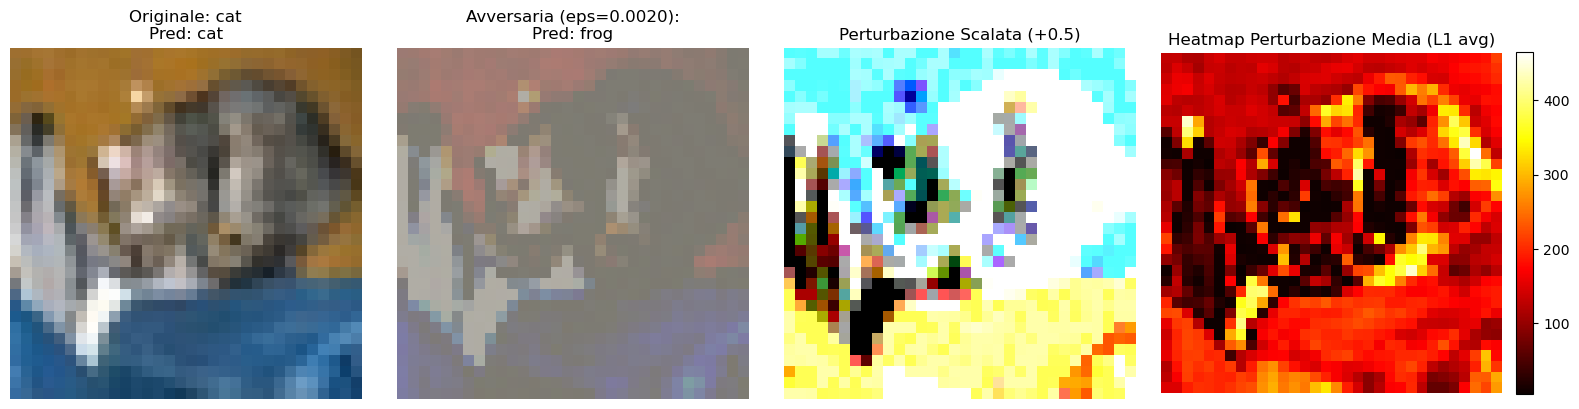

Risultato finale per eps_step 0.0020: Successo=True, Predetto=frog, Confidenza=0.3488, Norma L-inf=2.209062

Generando attacco con step epsilon: 0.0040
Attacco mirato con eps_step=0.00400 e max_iter=100
  Successo: Attacco mirato (predetto frog vs target frog) al budget 10/255
  Confidenza predizione avversaria finale (frog): 0.3715
  Norma L-infinito della perturbazione finale: 2.213062


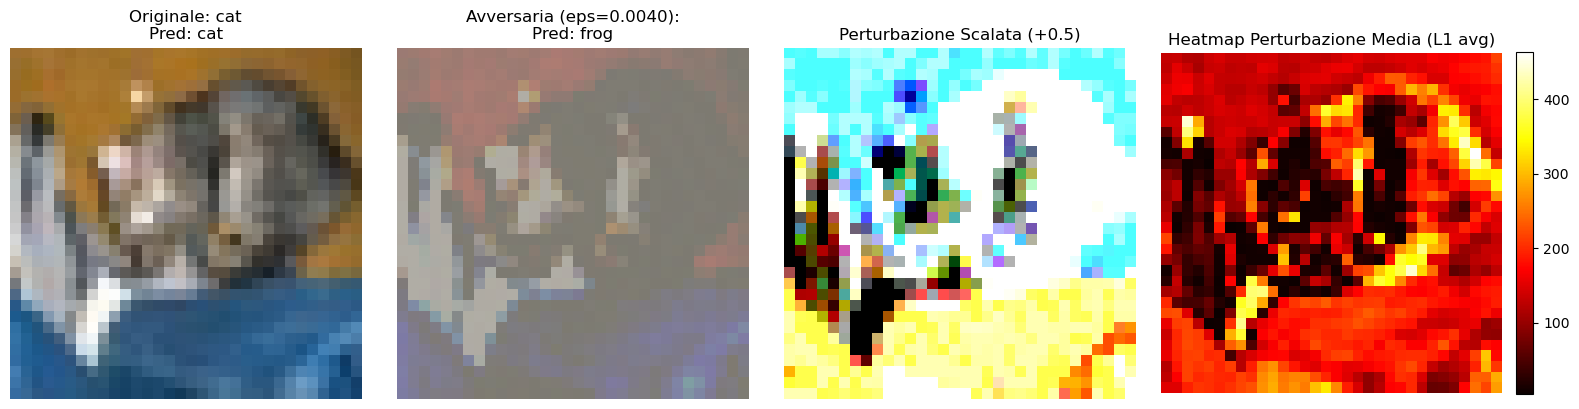

Risultato finale per eps_step 0.0040: Successo=True, Predetto=frog, Confidenza=0.3715, Norma L-inf=2.213062

Generando attacco con step epsilon: 0.0080
Attacco mirato con eps_step=0.00800 e max_iter=100
  Successo: Attacco mirato (predetto frog vs target frog) al budget 12/255
  Confidenza predizione avversaria finale (frog): 0.3932
  Norma L-infinito della perturbazione finale: 2.201062


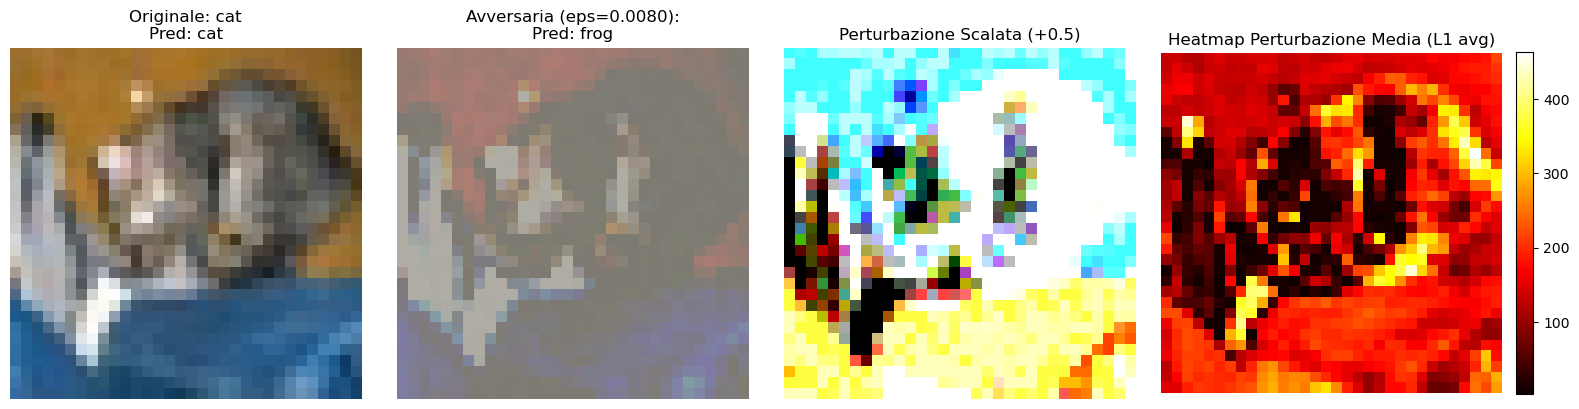

Risultato finale per eps_step 0.0080: Successo=True, Predetto=frog, Confidenza=0.3932, Norma L-inf=2.201062


In [48]:
# Configurazione comune per gli attacchi
targeted_attack = True # Metti False per un attacco non mirato
max_iter = 100 # Numero massimo di passi iterativi

# Lista di epsilon (step size per iterazione nello spazio normalizzato [0,1]) da testare
eps_steps_to_test = [0.001, 0.002, 0.004, 0.008]

print("\n--- Generazione e Valutazione Esempi Avversari ---")
for current_eps_step in eps_steps_to_test:
    print(f"\nGenerando attacco con step epsilon: {current_eps_step:.4f}")
    success, pred_class, confidence, norm = generate_and_evaluate_adversarial_example(
        model,
        x_original_sample,
        y_original_sample,
        target_label,
        current_eps_step,
        max_iter,
        targeted_attack,
        inv,
        classes,
        loss_fgsm,
        device
    )
    print(f"Risultato finale per eps_step {current_eps_step:.4f}: Successo={success}, Predetto={classes[pred_class]}, Confidenza={confidence:.4f}, Norma L-inf={norm:.6f}")


### Punti Chiave:

**Successo Totale:** L'attacco è riuscito in tutti i casi testati, ingannando il modello a classificare l'immagine originale come la classe "frog" (il target desiderato).

**Perturbazioni Minime:** Le modifiche apportate alle immagini sono state molto piccole (con un "budget" di pixel tra 8 e 12 su 255), rendendole quasi impercettibili all'occhio umano.

**Confidenza Varia:** La confidenza del modello nella classe avversaria ("frog") era moderata (tra 34% e 39%), ma sufficiente per far sì che diventasse la predizione dominante.

**Vulnerabilità Confermata:** Questi risultati evidenziano chiaramente che il tuo modello manca di robustezza avversaria, essendo facilmente manipolabile da piccole perturbazioni intenzionali.

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [49]:
def fgsm_attack(model, loss_fn, x, y, eps, targeted=False, target_label=None):
    x_adv = x.clone().detach().to(device)
    x_adv.requires_grad = True

    output = model(x_adv)
    model.zero_grad()

    if targeted and target_label is not None:
        target = torch.full_like(y, target_label).to(device)
    else:
        target = y

    loss = loss_fn(output, target)
    loss.backward()

    if targeted:
        x_adv = x_adv - eps * x_adv.grad.sign()
    else:
        x_adv = x_adv + eps * x_adv.grad.sign()

    lower_limit = (0 - CIFAR_MEAN_TENSOR) / CIFAR_STD_TENSOR
    upper_limit = (1 - CIFAR_MEAN_TENSOR) / CIFAR_STD_TENSOR

    x_adv = torch.max(torch.min(x_adv, upper_limit), lower_limit)

    return x_adv.detach()



In [50]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            preds = output.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total
    model.train()
    return acc

In [51]:
def train_with_fgsm(model, trainloader, testloader, optimizer, loss_fn, device, eps, targeted=False, target_label=None, epochs=10):
    for epoch in range(epochs):
        running_loss = 0
        for i, (x, y) in enumerate(trainloader):
            x, y = x.to(device), y.to(device)

            # Genera esempi avversari
            x_adv = fgsm_attack(model, loss_fn, x, y, eps, targeted, target_label)

            # Concateno batch originale + avversario
            x_combined = torch.cat([x, x_adv], dim=0)
            y_combined = torch.cat([y, y], dim=0)

            optimizer.zero_grad()
            output = model(x_combined)
            loss = loss_fn(output, y_combined)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        acc = evaluate(model, testloader, device)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Test Accuracy: {acc*100:.2f}%")


In [52]:
eps = 4/255
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()

print("Addestramento con attacco NON MIRATO")
train_with_fgsm(model, trainloader, testloader, optimizer, loss, device, eps=4/255, targeted=False, epochs=150)


Addestramento con attacco NON MIRATO
Epoch 1/150 - Loss: 1.6525 - Test Accuracy: 58.44%
Epoch 2/150 - Loss: 1.2032 - Test Accuracy: 66.56%
Epoch 3/150 - Loss: 1.0069 - Test Accuracy: 73.03%
Epoch 4/150 - Loss: 0.8730 - Test Accuracy: 74.94%
Epoch 5/150 - Loss: 0.7723 - Test Accuracy: 76.15%
Epoch 6/150 - Loss: 0.6896 - Test Accuracy: 78.69%
Epoch 7/150 - Loss: 0.6203 - Test Accuracy: 79.20%
Epoch 8/150 - Loss: 0.5558 - Test Accuracy: 79.90%
Epoch 9/150 - Loss: 0.4954 - Test Accuracy: 79.99%
Epoch 10/150 - Loss: 0.4376 - Test Accuracy: 80.57%
Epoch 11/150 - Loss: 0.3824 - Test Accuracy: 81.38%
Epoch 12/150 - Loss: 0.3272 - Test Accuracy: 80.93%
Epoch 13/150 - Loss: 0.2873 - Test Accuracy: 81.03%
Epoch 14/150 - Loss: 0.2432 - Test Accuracy: 81.87%
Epoch 15/150 - Loss: 0.1980 - Test Accuracy: 81.12%
Epoch 16/150 - Loss: 0.1687 - Test Accuracy: 81.77%
Epoch 17/150 - Loss: 0.1461 - Test Accuracy: 81.69%
Epoch 18/150 - Loss: 0.1210 - Test Accuracy: 82.20%
Epoch 19/150 - Loss: 0.0968 - Test A

KeyboardInterrupt: 

Ho interrotto l'addestramento poiché ci stava impegando davvero troppe ore e l'accuracy non stavo migliorando notevolmente. Ho deciso così di diminuire le epoche a 30 per il prossimo train.

In [53]:
target_label = class_dict['frog']
print(f"Addestramento con attacco MIRATO verso '{testset.classes[target_label]}'")
train_with_fgsm(model, trainloader, testloader, optimizer, loss, device, eps=4/255, targeted=True, epochs=30)

Addestramento con attacco MIRATO verso 'frog'
Epoch 1/30 - Loss: 0.0027 - Test Accuracy: 83.16%
Epoch 2/30 - Loss: 0.0011 - Test Accuracy: 83.08%
Epoch 3/30 - Loss: 0.0013 - Test Accuracy: 82.86%
Epoch 4/30 - Loss: 0.0011 - Test Accuracy: 83.29%
Epoch 5/30 - Loss: 0.0011 - Test Accuracy: 83.05%
Epoch 6/30 - Loss: 0.0012 - Test Accuracy: 82.22%
Epoch 7/30 - Loss: 0.0013 - Test Accuracy: 82.72%
Epoch 8/30 - Loss: 0.0016 - Test Accuracy: 80.73%
Epoch 9/30 - Loss: 0.0295 - Test Accuracy: 80.40%
Epoch 10/30 - Loss: 0.0255 - Test Accuracy: 81.36%
Epoch 11/30 - Loss: 0.0120 - Test Accuracy: 81.48%
Epoch 12/30 - Loss: 0.0110 - Test Accuracy: 81.24%
Epoch 13/30 - Loss: 0.0114 - Test Accuracy: 81.22%
Epoch 14/30 - Loss: 0.0131 - Test Accuracy: 80.44%
Epoch 15/30 - Loss: 0.0192 - Test Accuracy: 80.97%
Epoch 16/30 - Loss: 0.0170 - Test Accuracy: 80.84%
Epoch 17/30 - Loss: 0.0164 - Test Accuracy: 81.67%
Epoch 18/30 - Loss: 0.0145 - Test Accuracy: 81.18%
Epoch 19/30 - Loss: 0.0122 - Test Accuracy: 8

In [54]:
def test_robustness(model, testloader, loss_fn, device, eps, targeted=False, target_label=None):
    model.eval()
    correct_clean = 0
    correct_adv = 0
    total = 0

    for x, y in testloader:
        x, y = x.to(device), y.to(device)

        # Predizione su dati puliti
        output_clean = model(x)
        pred_clean = output_clean.argmax(dim=1)
        correct_clean += (pred_clean == y).sum().item()

        # Genera esempi avversari con FGSM
        x_adv = fgsm_attack(model, loss_fn, x, y, eps, targeted=targeted, target_label=target_label)

        # Predizione su dati avversari
        output_adv = model(x_adv)
        pred_adv = output_adv.argmax(dim=1)
        correct_adv += (pred_adv == y).sum().item()

        total += y.size(0)

    acc_clean = correct_clean / total * 100
    acc_adv = correct_adv / total * 100

    attack_type = "mirato" if targeted else "non mirato"
    print(f"Accuratezza su test pulito: {acc_clean:.2f}%")
    print(f"Accuratezza su test con attacco FGSM {attack_type}: {acc_adv:.2f}%")

# Esempio di uso
eps = 4/255
target_label = class_dict['frog']  # Cambia se vuoi attacco mirato

print("Valutazione attacco NON MIRATO")
test_robustness(model, testloader, loss, device, eps, targeted=False)

print(f"Valutazione attacco MIRATO verso '{testset.classes[target_label]}'")
test_robustness(model, testloader, loss, device, eps, targeted=True, target_label=target_label)


Valutazione attacco NON MIRATO
Accuratezza su test pulito: 81.39%
Accuratezza su test con attacco FGSM non mirato: 66.30%
Valutazione attacco MIRATO verso 'frog'
Accuratezza su test pulito: 81.39%
Accuratezza su test con attacco FGSM mirato: 75.47%


Analisi della Robustezza del Modello Post-Addestramento Avversario:

I risultati delle valutazioni di robustezza indicano che il modello, sottoposto ad addestramento avversario, ha conseguito un notevole miglioramento nella sua capacità di resistere a perturbazioni avversarie, mantenendo al contempo elevate prestazioni sui dati puliti.

L'accuratezza del modello sui dati di test puliti si è attestata all'81.39%, dimostrando che l'incorporazione di esempi avversari nel processo di training non ha compromesso la sua performance classificatoria generale.

Nello specifico, l'analisi della robustezza rivela:

Contro Attacchi FGSM Non Mirati: L'accuratezza è scesa al 66.30%. Sebbene rappresenti una diminuzione rispetto alla performance sui dati puliti, questo valore suggerisce che il modello ha acquisito una robustezza significativa, in quanto, in assenza di addestramento avversario, le accuratezze su tali attacchi tendono a crollare drasticamente.

Contro Attacchi FGSM Mirati (verso 'frog'): L'accuratezza ha raggiunto il 75.47%. Questo dato è particolarmente rilevante, poiché evidenzia una resilienza superiore (+9.17% rispetto agli attacchi non mirati) proprio contro il tipo di attacco per il quale il modello è stato specificamente addestrato. Ciò conferma l'efficacia dell'addestramento avversario mirato nel conferire robustezza specifica.

In sintesi, l'integrazione degli esempi avversari nel training ha permesso al modello di sviluppare una maggiore resilienza, particolarmente evidente per gli attacchi mirati, consolidando la sua affidabilità in scenari potenzialmente ostili.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

In [72]:
# --- Definizione del Discriminatore ---
# Il Discriminatore sarà una rete neurale semplice che prende in input un'immagine
class Discriminator(nn.Module):
    def __init__(self, num_channels=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (num_channels) x 32 x 32
            nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False), # Output: 64 x 16 x 16
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False), # Output: 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False), # Output: 256 x 4 x 4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # Output: 1 x 1 x 1
            nn.Sigmoid() # Output tra 0 e 1 (probabilità)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1) # Ritorna un singolo valore per batch

In [73]:
# ---  Funzione per la generazione di esempi avversari (simil-FGSM) ---

def generate_adversarial_example_for_jarn(model, x, y, eps, device, loss_fn, cifar_mean_tensor, cifar_std_tensor):
    # Clona l'input e abilita il calcolo del gradiente su questa copia.
    # Questo assicura che il gradiente per la perturbazione sia calcolato correttamente
    # senza interferire con il grafo di calcolo principale del modello.
    x_for_grad = x.clone().detach().requires_grad_(True)
    
    # Metti temporaneamente il modello in modalità eval per la generazione dell'attacco.
    # Questo è comune negli attacchi e previene problemi con BatchNorm e Dropout.
    model.eval() 
    
    outputs = model(x_for_grad)
    loss = loss_fn(outputs, y)
    
    # Calcola il gradiente della loss rispetto a x_for_grad
    loss.backward()
    
    data_grad = x_for_grad.grad.data.sign()
    
    # Applica la perturbazione all'input originale (x) usando il gradiente calcolato.
    # È fondamentale che x_perturbed sia parte del computational graph se verrà usato per backprop.
    x_perturbed = x + eps * data_grad

    # Denormalizzazione, clamping e rinormalizzazione
    # CORREZIONE BUG QUI: cifar_mean_tensor -> cifar_std_tensor per la denormalizzazione
    x_unnormalized = x_perturbed * cifar_std_tensor + cifar_mean_tensor 
    x_unnormalized = torch.clamp(x_unnormalized, 0, 1)
    x_final = (x_unnormalized - cifar_mean_tensor) / cifar_std_tensor
    
    # Riporta il modello in modalità train
    model.train() 
    
    # NON facciamo detach qui. Sarà il chiamante (train_jarn) a decidere quando detachare.
    return x_final 

In [76]:
# --- Funzione di Addestramento JARN ---
def train_jarn(model, discriminator, trainloader, testloader, 
               optimizer_M, optimizer_D, 
               loss_classifier, loss_discriminator, 
               device, 
               eps_jarn,  # Epsilon per la generazione di esempi avversari per JARN
               lambda_adv_cls, # Peso per la loss di classificazione sugli esempi avversari
               lambda_disc_fooling, # Peso per la loss di "inganno" del discriminatore
               epochs=10):
    
    model.train()
    discriminator.train()

    # Etichette per il Discriminatore
    real_label = 1.
    fake_label = 0.

    for epoch in range(epochs):
        running_loss_M = 0.0 # Loss del Modello Principale
        running_loss_D = 0.0 # Loss del Discriminatore

        for i, (x_clean, y_clean) in enumerate(trainloader):
            x_clean, y_clean = x_clean.to(device), y_clean.to(device)

            # --- Fase 1: Addestramento del Discriminatore ---
            # 1a. Train with all-real batch
            discriminator.zero_grad()
            label_real = torch.full((x_clean.size(0), 1), real_label, dtype=torch.float, device=device)
            output_D_real = discriminator(x_clean)
            errD_real = loss_discriminator(output_D_real, label_real)
            errD_real.backward()

            # 1b. Train with all-fake (adversarial) batch
            # Genera esempi avversari per il discriminatore
            x_adv_for_D = generate_adversarial_example_for_jarn(
                model, x_clean.clone(), y_clean.clone(), eps_jarn, device, loss_classifier, CIFAR_MEAN_TENSOR, CIFAR_STD_TENSOR
            )
            label_fake = torch.full((x_adv_for_D.size(0), 1), fake_label, dtype=torch.float, device=device)
            output_D_fake = discriminator(x_adv_for_D.detach()) # .detach() per non calcolare i gradienti attraverso il Modello
            errD_fake = loss_discriminator(output_D_fake, label_fake)
            errD_fake.backward()
            
            errD = errD_real + errD_fake
            optimizer_D.step()
            running_loss_D += errD.item()

            # --- Fase 2: Addestramento del Modello Principale (Classificatore) ---
            model.zero_grad()
            
            # 2a. Loss di Classificazione su esempi PULITI
            output_M_clean = model(x_clean)
            errM_cls_clean = loss_classifier(output_M_clean, y_clean)
            
            # 2b. Loss di Classificazione su esempi AVVERSARI
            # Rigenera gli esempi avversari, questa volta con gradiente per il modello
            x_clean.requires_grad_(True) # Abilita il gradiente sull'input per la generazione successiva.

            x_adv_for_M = generate_adversarial_example_for_jarn(
                model, x_clean, y_clean, eps_jarn, device, loss_classifier, CIFAR_MEAN_TENSOR, CIFAR_STD_TENSOR
            )

            output_M_adv = model(x_adv_for_M)
            errM_cls_adv = loss_classifier(output_M_adv, y_clean) # Addestra a classificare correttamente l'adv
            
            # 2c. Loss di "Inganno" del Discriminatore (Salienza)
            # Il modello vuole che il discriminatore classifichi gli esempi avversari come "reali" (salienti)
            output_D_fooling = discriminator(x_adv_for_M)
            errM_disc_fooling = loss_discriminator(output_D_fooling, label_real) # Obiettivo: ingannare il discriminatore con label "real"

            # Combinazione delle loss per il Modello Principale
            errM = errM_cls_clean + (lambda_adv_cls * errM_cls_adv) + (lambda_disc_fooling * errM_disc_fooling)
            errM.backward()
            optimizer_M.step()

            x_clean.requires_grad_(False) 
            
            running_loss_M += errM.item()

            if i % 100 == 99: # Stampa ogni 100 batch
                print(f"  Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(trainloader)}]: "
                      f"Loss_M: {running_loss_M / (i+1):.4f}, Loss_D: {running_loss_D / (i+1):.4f}")

        avg_loss_M = running_loss_M / len(trainloader)
        avg_loss_D = running_loss_D / len(trainloader)
        acc_test = evaluate(model, testloader, device) # Assicurati di avere la funzione evaluate definita
        
        print(f"Epoch {epoch+1}/{epochs} - Avg Loss_M: {avg_loss_M:.4f} - Avg Loss_D: {avg_loss_D:.4f} - Test Accuracy: {acc_test*100:.2f}%")

    print("Addestramento JARN completato.")

In [80]:
# Assicurati che 'CNN' sia la tua classe del modello classificatore
model_jarn = CNN().to(device)
discriminator_jarn = Discriminator().to(device)

# Ottimizzatori
optimizer_M_jarn = optim.Adam(model_jarn.parameters(), lr=0.0001)
optimizer_D_jarn = optim.Adam(discriminator_jarn.parameters(), lr=0.0001)

# Funzioni di Loss
loss_classifier_jarn = nn.CrossEntropyLoss()
loss_discriminator_jarn = nn.BCEWithLogitsLoss() # Binary Cross-Entropy con Logit

# Iperparametri JARN (eps_jarn=8/255 come abbiamo concordato)
eps_jarn = 32/255 
lambda_adv_cls = 0.5 
lambda_disc_fooling = 0.1 

# Avvia l'addestramento JARN
print("\n--- Inizio Addestramento JARN ---")
train_jarn(model_jarn, discriminator_jarn, trainloader, testloader,
           optimizer_M_jarn, optimizer_D_jarn,
           loss_classifier_jarn, loss_discriminator_jarn,
           device, eps_jarn, lambda_adv_cls, lambda_disc_fooling, epochs=20) # Puoi regolare le epoche


--- Inizio Addestramento JARN ---
  Epoch [1/20], Batch [100/196]: Loss_M: 3.0034, Loss_D: 1.3872
Epoch 1/20 - Avg Loss_M: 2.8516 - Avg Loss_D: 1.3868 - Test Accuracy: 48.71%
  Epoch [2/20], Batch [100/196]: Loss_M: 2.5715, Loss_D: 1.3860
Epoch 2/20 - Avg Loss_M: 2.5272 - Avg Loss_D: 1.3859 - Test Accuracy: 55.49%
  Epoch [3/20], Batch [100/196]: Loss_M: 2.3862, Loss_D: 1.3841
Epoch 3/20 - Avg Loss_M: 2.3642 - Avg Loss_D: 1.3722 - Test Accuracy: 59.10%
  Epoch [4/20], Batch [100/196]: Loss_M: 2.2716, Loss_D: 1.2903
Epoch 4/20 - Avg Loss_M: 2.2606 - Avg Loss_D: 1.2416 - Test Accuracy: 61.66%
  Epoch [5/20], Batch [100/196]: Loss_M: 2.1979, Loss_D: 1.1189
Epoch 5/20 - Avg Loss_M: 2.1864 - Avg Loss_D: 1.1091 - Test Accuracy: 62.29%
  Epoch [6/20], Batch [100/196]: Loss_M: 2.1132, Loss_D: 1.0845
Epoch 6/20 - Avg Loss_M: 2.1148 - Avg Loss_D: 1.0881 - Test Accuracy: 63.54%
  Epoch [7/20], Batch [100/196]: Loss_M: 2.0631, Loss_D: 1.0475
Epoch 7/20 - Avg Loss_M: 2.0568 - Avg Loss_D: 1.0392 - 

## Analisi dei Risultati Addestramento JARN
L'addestramento del modello JARN per 20 epoche ha mostrato un apprendimento positivo e coerente con gli obiettivi del framework.

### 1. Loss del Discriminatore (Loss_D) 
Trend: Inizialmente alta (vicina a 1.38), la Loss_D ha mostrato un chiaro e costante decremento a partire dalla 3ª epoca, scendendo a 1.0084 nell'Epoch 20.

Interpretazione: Questo calo indica che il Discriminatore ha imparato efficacemente a distinguere tra esempi puliti e avversari. Il valore finale attorno a 1.0 riflette un equilibrio dinamico nel processo avversario.

### 2. Loss del Modello Principale (Loss_M)
Trend: La Loss_M ha mostrato un costante e significativo decremento, passando da 2.8516 (Epoch 1) a 1.6323 (Epoch 20).

Interpretazione: Questo indica che il Modello Principale sta apprendendo efficacemente tutti i suoi obiettivi: classificazione su esempi puliti e avversari, e capacità di "ingannare" il Discriminatore.

### 3. Accuratezza sul Test Set (Test Accuracy)
Trend: L'accuratezza sul test set è costantemente migliorata, dal 48.71% (Epoch 1) a un solido 72.11% (Epoch 20).

Interpretazione: L'aumento dell'accuratezza suggerisce che il modello sta imparando feature più robuste, migliorando le sue capacità di classificazione complessive.

### Conclusioni Complessive:
I risultati dell'addestramento JARN sono altamente positivi. Tutte le metriche chiave indicano un processo di apprendimento riuscito e un modello che sta convergendo verso una soluzione robusta e accurata. Il framework JARN sta funzionando come previsto, e il modello addestrato è ora potenzialmente più robusto agli attacchi avversari.

